In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.0 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, pipeline
import torch
from transformers import TrainingArguments, Trainer

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/dataset/p4k_reviews_dataset_processed.pkl')

In [ ]:
df

,url,score,pub_year,text
0,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,2017,"“Trip-hop” eventually became a ’90s punchline,..."
1,http://pitchfork.com/reviews/albums/22721-prel...,7.9,2017,"Eight years, five albums, and two EPs in, the ..."
2,http://pitchfork.com/reviews/albums/22659-all-...,7.3,2017,Minneapolis’ Uranium Club seem to revel in bei...
3,http://pitchfork.com/reviews/albums/22661-firs...,9.0,2017,Kleenex began with a crash. It transpired one ...
4,http://pitchfork.com/reviews/albums/22725-new-...,8.1,2017,It is impossible to consider a given release b...
...,...,...,...,...
17995,http://pitchfork.com/reviews/albums/6970-sound...,7.7,2000,"When last we heard from Saint Etienne, on last..."
17996,http://pitchfork.com/reviews/albums/1359-the-a...,5.6,2000,Some things are unfairly dependent on the vaga...
17997,http://pitchfork.com/reviews/albums/7601-mwng/,7.9,2000,For a territory only slightly larger than New ...
17998,http://pitchfork.com/reviews/albums/3824-home-...,6.0,2000,"PSAs on TV tell kids ""don't smoke"" and ""just s..."


<Axes: ylabel='Frequency'>

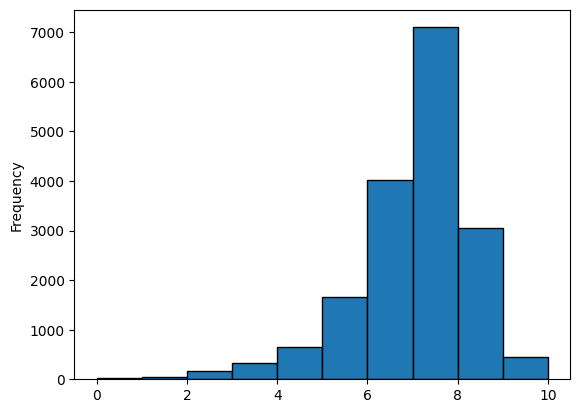

In [ ]:
df['score'].plot(kind='hist', edgecolor='black')

In [ ]:
df['score'].value_counts()

7.0    878
7.5    839
7.8    835
8.0    815
7.4    749
      ... 
9.9      1
0.9      1
1.1      1
0.7      1
0.1      1
Name: score, Length: 100, dtype: int64

In [ ]:
nMax = 60

res = df.groupby('score').apply(lambda x: x.sample(n=min(nMax, len(x))))
pd.set_option('display.max_rows', 500)
print(res['score'].value_counts())

5.1     60
4.7     60
6.8     60
6.7     60
6.6     60
6.5     60
6.4     60
6.3     60
6.2     60
6.1     60
6.0     60
5.9     60
5.8     60
5.7     60
5.6     60
5.5     60
5.4     60
5.3     60
5.2     60
5.0     60
4.9     60
6.9     60
7.0     60
7.1     60
8.2     60
9.0     60
8.9     60
8.8     60
8.7     60
8.6     60
8.5     60
8.4     60
8.3     60
8.1     60
7.2     60
8.0     60
7.9     60
7.8     60
7.7     60
7.6     60
7.5     60
7.4     60
7.3     60
4.8     60
10.0    60
4.0     60
4.5     60
9.2     58
4.4     57
3.8     56
9.1     55
4.6     51
4.2     49
9.3     47
9.5     45
3.5     45
3.9     44
4.1     40
3.0     38
4.3     36
9.4     34
3.7     32
3.3     30
2.0     25
2.9     25
2.8     23
3.2     23
3.4     21
3.6     20
2.7     18
2.5     15
3.1     15
2.6     13
9.7     13
2.1     12
2.4     11
9.6     11
2.3     10
2.2      9
1.9      9
1.0      7
1.8      6
1.5      5
0.0      4
9.8      4
0.4      4
1.2      4
0.8      3
0.6      3
1.7      3
0.2      3

<Axes: ylabel='Frequency'>

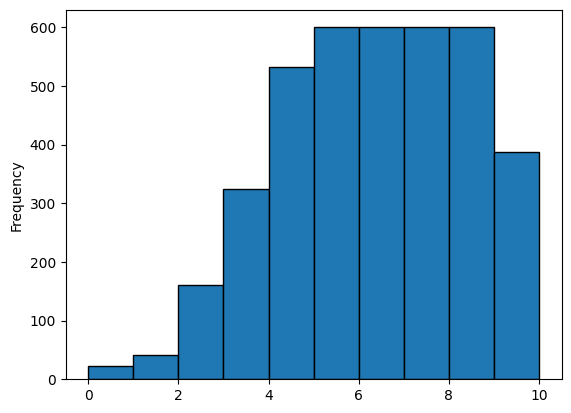

In [ ]:
res['score'].plot(kind='hist', edgecolor='black')

In [ ]:
res

url  score  \
score                                                                   
0.0   14537  http://pitchfork.com/reviews/albums/5607-travi...    0.0   
      15899  http://pitchfork.com/reviews/albums/6255-liz-p...    0.0   
      13899  http://pitchfork.com/reviews/albums/6383-relax...    0.0   
      11067  http://pitchfork.com/reviews/albums/10571-this...    0.0   
0.1   17330  http://pitchfork.com/reviews/albums/6516-feel-...    0.1   
...                                                        ...    ...   
10.0  6089   http://pitchfork.com/reviews/albums/16000-the-...   10.0   
      861    http://pitchfork.com/reviews/albums/21841-purp...   10.0   
      8621   http://pitchfork.com/reviews/albums/13431-abbe...   10.0   
      8835   http://pitchfork.com/reviews/albums/13130-reck...   10.0   
      3214   http://pitchfork.com/reviews/albums/19182-slin...   10.0   

             pub_year                                               text  
score                                                                     
0.0   14537      2004  Travis Morrison got his ass kicked. He tells t...  
      15899      2003  It could be said that Liz Phair's greatest ass...  
      13899      2005  If more drunks would learn from Robert Pollard...  
      11067      2007  "Indie's Biggest Hits"? "Volume 1"? "NOW that'...  
0.1   17330      2002  Contrary to what you may believe, it's hard to...  
...               ...                                                ...  
10.0  6089       2011  It's a rite of passage for students of pop mus...  
      861        2016  Prior to Purple Rain, the backstory Prince had...  
      8621       2009  One more "like we used to" was how Paul McCart...  
      8835       2009  Given their vast and varied catalog, it's some...  
      3214       2014  “We’re from Louisville, and we thought you nee...  

[3869 rows x 4 columns]

In [ ]:
res.to_pickle("./p4k_reviews_dataset_processed_balanced.pkl")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
df = pd.read_pickle('p4k_reviews_dataset_processed_balanced.pkl')
df = df.reset_index(drop=True)
df

,url,score,pub_year,text
0,http://pitchfork.com/reviews/albums/5607-travistan/,0.0,2004,"Travis Morrison got his ass kicked. He tells the whole story here, about the random beatdown he ..."
1,http://pitchfork.com/reviews/albums/6255-liz-phair/,0.0,2003,It could be said that Liz Phair's greatest asset has always been her inability to write a perfec...
2,http://pitchfork.com/reviews/albums/6383-relaxation-of-the-asshole/,0.0,2005,"If more drunks would learn from Robert Pollard, simply accept his teachings, alcoholism wouldn't..."
3,http://pitchfork.com/reviews/albums/10571-this-is-next/,0.0,2007,"""Indie's Biggest Hits""? ""Volume 1""? ""NOW that's what I call indie!"" jokes aside, This Is Next is..."
4,http://pitchfork.com/reviews/albums/6516-feel-no-fade/,0.1,2002,"Contrary to what you may believe, it's hard to achieve a ranking this low. Your friends at Pitch..."
...,...,...,...,...
3864,http://pitchfork.com/reviews/albums/16000-the-smile-sessions/,10.0,2011,"It's a rite of passage for students of pop music history: At some point, you learn that the Beac..."
3865,http://pitchfork.com/reviews/albums/21841-purple-rain/,10.0,2016,"Prior to Purple Rain, the backstory Prince had created for himself was that of a sex-obsessed R&..."
3866,http://pitchfork.com/reviews/albums/13431-abbey-road/,10.0,2009,"One more ""like we used to"" was how Paul McCartney framed it to producer George Martin; a chance ..."
3867,http://pitchfork.com/reviews/albums/13130-reckoning-deluxe-edition/,10.0,2009,"Given their vast and varied catalog, it's sometimes easier to imagine R.E.M. as a discography th..."


In [ ]:
dataX = df['text']
dataY = df['score']
dataX.head(5), dataY.head(5)

(0    Travis Morrison got his ass kicked. He tells the whole story here, about the random beatdown he ...
 1    It could be said that Liz Phair's greatest asset has always been her inability to write a perfec...
 2    If more drunks would learn from Robert Pollard, simply accept his teachings, alcoholism wouldn't...
 3    "Indie's Biggest Hits"? "Volume 1"? "NOW that's what I call indie!" jokes aside, This Is Next is...
 4    Contrary to what you may believe, it's hard to achieve a ranking this low. Your friends at Pitch...
 Name: text, dtype: object,
 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.1
 Name: score, dtype: float64)

In [ ]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

In [ ]:
raw_train_df = pd.concat([x_train, y_train], axis=1)
raw_test_df = pd.concat([x_test, y_test], axis=1)
raw_val_df = pd.concat([x_val, y_val], axis=1)

In [ ]:
raw_train_ds = Dataset.from_pandas(raw_train_df)
raw_test_ds = Dataset.from_pandas(raw_test_df)
raw_val_ds = Dataset.from_pandas(raw_val_df)

In [ ]:
print(raw_train_ds, raw_val_ds, raw_test_ds)

Dataset({
    features: ['text', 'score', '__index_level_0__'],
    num_rows: 3095
}) Dataset({
    features: ['text', 'score', '__index_level_0__'],
    num_rows: 387
}) Dataset({
    features: ['text', 'score', '__index_level_0__'],
    num_rows: 387
})


In [ ]:
BASE_MODEL = "allenai/longformer-base-4096"
LEARNING_RATE = 2e-5
MAX_LENGTH = 2048
BATCH_SIZE = 4
EPOCHS = 5

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight'

In [ ]:
ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}

def preprocess_function(examples):
    label = examples["score"]
    examples = tokenizer(examples["text"], padding='max_length', truncation=True, max_length=MAX_LENGTH)

    # Change this to real number
    examples["label"] = float(label)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["text", "score"])

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]

Map:   0%|          | 0/387 [00:00<?, ? examples/s]

Map:   0%|          | 0/387 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = math.sqrt(mean_squared_error(labels, logits))
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()


    return {"mse": mse, "mae": mae, "r2": r2}

In [ ]:
training_args = TrainingArguments(
    output_dir="./models/longformer-fine-tuned-regression-2",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="mse",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [ ]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
%%time
torch.cuda.empty_cache()
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Mae,R2
1,3.383800,1.071533,1.071533,0.765685,0.753034
2,1.035300,0.953431,0.953431,0.746400,0.780254
3,0.639400,0.827895,0.827895,0.688138,0.809187
4,0.379100,0.756967,0.756967,0.669465,0.825535
5,0.266000,0.737149,0.737149,0.668268,0.830102


CPU times: user 56min 44s, sys: 13.6 s, total: 56min 57s
Wall time: 56min 50s


TrainOutput(global_step=3870, training_loss=0.998093735648064, metrics={'train_runtime': 3404.2283, 'train_samples_per_second': 4.546, 'train_steps_per_second': 1.137, 'total_flos': 2.03294111499264e+16, 'train_loss': 0.998093735648064, 'epoch': 5.0})

In [ ]:
trainer.eval_dataset=ds["test"]
trainer.evaluate()

{'eval_loss': 1.0715328454971313,
 'eval_mse': 1.0715327262878418,
 'eval_mae': 0.765685498714447,
 'eval_r2': 0.7530339184394305,
 'eval_runtime': 21.4079,
 'eval_samples_per_second': 18.077,
 'eval_steps_per_second': 4.531,
 'epoch': 5.0}

In [ ]:
nb_batches = math.ceil(len(raw_test_ds)/BATCH_SIZE)
y_preds = []

for i in range(nb_batches):
    input_texts = raw_test_ds[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["text"]
    input_labels = raw_test_ds[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["score"]
    encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_tensors="pt").to("cuda")
    y_preds += model(**encoded).logits.reshape(-1).tolist()


df1 = pd.DataFrame([raw_test_ds["text"], raw_test_ds["score"], y_preds], ["Text", "Score", "Prediction"]).T

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)
df1.sample(50)

,Text,Score,Prediction
264,"Lucky Pierre is the solo identity of Aidan Moffat, who until last year was the vocal half of Arab Strap. Malcolm Middleton handled most of the music in that outfit, but Moffat had plenty of the stuff in his own head, and since 2002 has kept a release schedule on the side even more prolific than ...",5.9,5.169007
259,"Not to be confused with the guitarded punks on Honest Don's that Pitchfork's own Charly Gordon called ""mildly entertaining,"" this band called Limp is four men from Denmark who spend most of their time apart, each making electronic music on their own. Jakob Skatt (Syntaks), Jonas Munk (Manual), R...",6.1,5.60651
39,"Atlanta, rap's 21st century capital, has been a place of many camps—So So Def, Grand Hustle, Corporate Thugz Entertainment, Bricksquad— that might on occasion work together, but more often have kept to themselves. The city's new generation doesn’t see such boundaries. Mike WiLL Made It works wit...",5.5,5.360414
290,"Love Your Dum and Mad begins with this insistent clanging; it's guitarist Simon McCabe hammering away on a zither, making some industrial-grade din-- the noise perfectly mimicing a train crossing signal. It's an anxious sound, the soundtrack of impatiently waiting, of staying clear of a powerful...",7.9,8.497203
232,"When Warp records released Gravenhurst's Flashlight Seasons earlier this year, the release was unfairly raked beneath 2004's already unwieldy pile of avant-folk artifacts, despite the fact that the lineage of Nick Talbot's atmospheric songcraft could more accurately be traced back through bands ...",7.3,5.830157
172,"Robbers on High Street's 2005 debut, Tree City, sounded rooted in urban spaces, specifically their adopted hometown of New York City, where they bore endless kneejerk comparisons first to local boys the Strokes and then to Austinites Spoon. With the latter ascendant and the Brooklyn scene putter...",5.3,5.533651
156,"WE'RE JUST TALKING... TO THE KIDS!When you start to measure the amount of music you listen to in gigabytes and jumbo-size Case Logics, it's easy to forget the awesome power of the simple declarative statement. Nothing against all those 30-piece ensembles, nautically focused concept albums, intri...",8.9,7.710275
118,"Used to be, way back in the twentieth century, that advertising was based on products, and told consumers all sorts of crazy crap like what the thing did and how much it cost. Somewhere along the line, though, advertisers wised up and realized that consumers didn't care that their Ford Gas Crisi...",4.4,3.317492
170,"If name-dropped correctly a little literature can go a long way. While trying to absorb the background information for Down for Whatever, a collection of run-of-the-mill garage-rock anthems by San Francisco's Vue, I came upon keyboardist Jessica Ann Graves' mention of one of William T. Vollmann'...",4.4,5.23456
109,"With their second full-length album, Chicago production duo Supreme Cuts attempt to make a big leap. Their 2012 debut Whispers in the Dark was a strikingly trendy and sometimes engrossing stew of bass beats that seemed more eager to confound than galvanize. There were few rhythms to groove to an...",4.2,5.345034


In [ ]:
#trainer.save_model('./drive/MyDrive/p4k-longformer-60')

In [ ]:
#tokenizer.save_pretrained("./drive/MyDrive/p4k-longformer-tokenizer-60")

In [ ]:
trainer.state.log_history

[{'loss': 3.3838,
  'learning_rate': 1.7416020671834626e-05,
  'epoch': 0.65,
  'step': 500},
 {'eval_loss': 1.0715328454971313,
  'eval_mse': 1.0715327262878418,
  'eval_mae': 0.765685498714447,
  'eval_r2': 0.7530339184394305,
  'eval_runtime': 21.333,
  'eval_samples_per_second': 18.141,
  'eval_steps_per_second': 4.547,
  'epoch': 1.0,
  'step': 774},
 {'loss': 1.3668,
  'learning_rate': 1.4832041343669253e-05,
  'epoch': 1.29,
  'step': 1000},
 {'loss': 1.0353,
  'learning_rate': 1.2248062015503876e-05,
  'epoch': 1.94,
  'step': 1500},
 {'eval_loss': 0.9534314274787903,
  'eval_mse': 0.9534314274787903,
  'eval_mae': 0.7463998198509216,
  'eval_r2': 0.7802538186256824,
  'eval_runtime': 21.3516,
  'eval_samples_per_second': 18.125,
  'eval_steps_per_second': 4.543,
  'epoch': 2.0,
  'step': 1548},
 {'loss': 0.6394,
  'learning_rate': 9.664082687338502e-06,
  'epoch': 2.58,
  'step': 2000},
 {'eval_loss': 0.8278947472572327,
  'eval_mse': 0.8278948068618774,
  'eval_mae': 0.688138

In [ ]:
pd.DataFrame(trainer.state.log_history)

NameError: ignored